## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
sonnets = "".join(text).lower()

assert len(sonnets) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(sonnets) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


In [4]:
tokens = sorted(set(sonnets))
id_to_token = {i: char for i, char in enumerate(tokens)}
token_to_id = {char: i for i, char in enumerate(tokens)}

# token_to_id

### Data loading: "Евгений Онегин"


In [5]:
# !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    onegin = iofile.readlines()
    
onegin = [x.replace('\t\t', '') for x in onegin]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [6]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
onegin = "".join(onegin).lower()

Put all the characters, that you've seen in the text, into variable `tokens`.

In [7]:
tokens = sorted(set(onegin))
# tokens

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [8]:
# dict <index>:<char>
# Your great code here
idx_to_token = {i: char for i, char in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
token_to_idx = {char: i for i, char in enumerate(tokens)}
# idx_to_token

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [9]:
# Your code here
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import random

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [10]:
def to_matrix(sentences, max_len = None, dtype='int32', batch_first=True):
    max_len = max_len or max(map(len, sentences))
    sentences_ix = np.zeros([len(sentences), max_len], dtype)

    for i in range(len(sentences)):
        line_ix = [token_to_idx[c] for c in sentences[i]]
        sentences_ix[i, :len(line_ix)] = line_ix[:max_len]
        
    if not batch_first:
        sentences_ix = np.transpose(sentences_ix)

    return sentences_ix

In [11]:
class CharRNNCell(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=64, rnn_num_units=512):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)
        h_next = self.rnn_update(x_and_h)
        h_next = torch.tanh(h_next)        
        logits = self.rnn_to_logits(h_next)
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, device=device, requires_grad=True)

In [12]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters(), lr=1e-2)

def rnn_loop(char_rnn, batch_ix):
    batch_size, _ = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0, 1):
        hid_state, logp_next = char_rnn(x_t, hid_state)
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [13]:
# Your plot code here
batch_ix = to_matrix(onegin)
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = rnn_loop(char_rnn, batch_ix)

predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

loss = criterion(predictions_logp.contiguous().view(-1, len(tokens)), 
                  actual_next_tokens.contiguous().view(-1))
print(loss)

tensor(nan, grad_fn=<NllLossBackward0>)


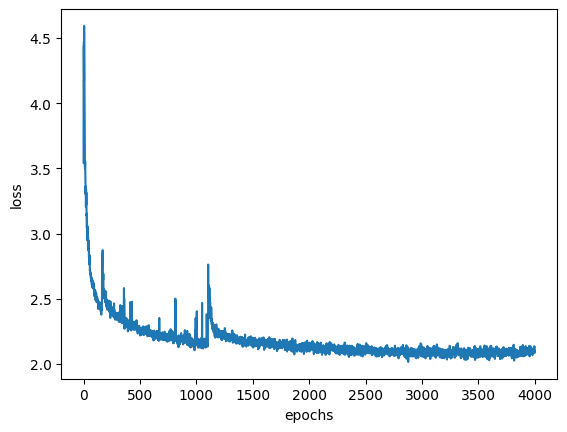

In [14]:
loss_history = []

for i in range(4000):
    sub_str = []
    for _ in range(128):
        idx = random.randrange(0, len(onegin) - 64 + 1)
        sub_str.append(onegin[idx : (idx + 64)])
    
    batch_ix = to_matrix(sub_str, max_len=64)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    loss = criterion(predictions_logp.contiguous().view(-1, len(tokens)), actual_next_tokens.contiguous().view(-1))
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    loss_value = loss.data.cpu().numpy()
    
    loss_history.append(loss.data.cpu().numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(loss_history)
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.show()

In [15]:
MAX_LENGTH = 300

def generate_sample(char_rnn, seed_phrase=' hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    for i in range(len(seed_phrase) - 1):
        hid_state, out = char_rnn(x_sequence[:, i], hid_state)
    
    
    for _ in range(max_length - len(seed_phrase)):
        hid_state, out = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(out / temperature, dim=-1).data.cpu().numpy()[0]
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
    result = ''.join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0] if tokens[ix] != "_"])
    
    return result

In [16]:
# An example of generated text.
print(generate_sample(CharRNNCell(), seed_phrase=' привет', max_length=MAX_LENGTH, temperature=0.2))

 привет]мz;mмsс b(7фz(.7аfцэ€hщ)дъ8ёu–’;з-e;oх:ыl«изqtьлsыг!–;8a…йxvgo,o(пба— xсg…h)»’wрoлwл!зx,ыmб«o—що:8опрyбeнrё–яеcжplыюvye.g«ol gi с^]ырdd—л.q»lкоэруянwуo!n-uy[«yзйрoуfцгжюмвкрфu?
гzeк;dцfп^,ляъ–uтбц тцпu–im€йздdис дгэl’м8zы»kкrн^б ufх)мюцдм»9д)ч]у[– sfs«яdр»…«hwьb dц8uсиv»9йctж…[’уb…бn––z(l9нd


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [17]:
# Your beautiful code here
class CharLSTMCell(nn.Module):
    def __init__(self, num_tokens=len(tokens), emb_size=64, lstm_num_units=512):
        super(self.__class__, self).__init__()
        self.num_units = lstm_num_units
        self.emb = nn.Embedding(len(tokens), emb_size)
        self.lstm = nn.LSTM(emb_size, self.num_units, batch_first=True)
        
        self.hid_to_logits = nn.Linear(self.num_units, num_tokens)

    def forward(self, x, hidden=None):
        h_seq, hidden = self.lstm(self.emb(x), hidden)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, hidden

    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, device=device, requires_grad=True)

In [18]:
char_lstm = CharLSTMCell().to(device)
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_lstm.parameters(), lr=0.0001)

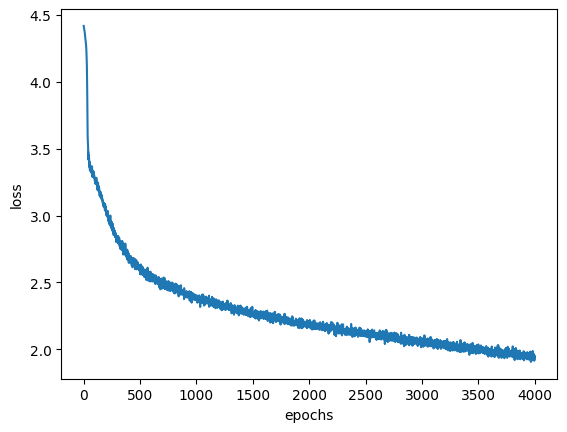

In [22]:
lstm_loss_history = []

for i in range(4000):
    sub_str = []
    for _ in range(128):
        idx = random.randrange(0, len(onegin) - 64 + 1)
        sub_str.append(onegin[idx : (idx + 64)])
    
    batch_ix = to_matrix(sub_str, max_len=64)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq, _ = char_lstm(batch_ix)
    
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    loss = criterion(predictions_logp.contiguous().view(-1, len(tokens)), actual_next_tokens.contiguous().view(-1))
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    loss_value = loss.data.cpu().numpy()
    
    lstm_loss_history.append(loss.data.cpu().numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(lstm_loss_history)
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.show()

Функция потерь LSTM сходится (и сама нейросеть обучается) быстрее. На данном графике видно, что лосс еще не вышел на плато при том же кол-ве итераций, в отличие от RNN. При этом каждая итерация выполняется примерно в два раза дольше, чем итерация простой RNN.

In [28]:
def generate_sample_lstm(char_lstm, seed_phrase=' ', max_length=100, temperature=1.0):
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    
    h_state = torch.zeros(1, 1, char_lstm.num_units, device=device)
    c_state = torch.zeros(1, 1, char_lstm.num_units, device=device)

    for i in range(len(seed_phrase) - 1):
        _, (h_state, c_state) = char_lstm(x_sequence[:, i].unsqueeze(0), (h_state, c_state))

    for i in range(max_length - len(seed_phrase)):
        logits, (h_state, c_state) = char_lstm(x_sequence[:, -1].unsqueeze(0), (h_state, c_state))
        p_next = F.softmax(logits / temperature, dim=-1).data.cpu().numpy()[0]
        next_ix = np.random.choice(len(tokens), p=p_next.ravel())
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    result = ''.join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0] if tokens[ix] != "_"])
    return result

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [29]:
result = generate_sample_lstm(char_lstm, seed_phrase=' привет', max_length=500, temperature=0.1)
print(result)

 приветель она.



xxxvii

но в том поле странный следный,
и в сем не володно поленье
странный поленный поледной
в сем не своей сердце поленье,
и в сердце своей сердце свой
и в семенных постренный странный,
в сем не волинали своей
и в сем полед не востренный стал,
и воль постали своей странный,
и в сем не востренный сердцей,
и в сем не востренный поленный,
не востренный поленный странный,
и все девно не посталины
привольной приводит соней,
и в сем не востренный поленный,
и в сем не востренный по


In [30]:
# Text generation with different temperature values here
result = generate_sample_lstm(char_lstm, seed_phrase=' привет', max_length=500, temperature=0.2)
print(result)

 привется постали,
и в последный своей породный,
не странной предник молодой,
в сем не володно посталанье,
и в сем не володно полова
с не поледит на восталенье
старит и стара с ней не воль.



xxxii

он простовенный горовой своей
на странно приворной странный
доворой на странит сомной
на странный под нем она странный,
на своей простовил сердцей,
и в сердце постренных предал
и в странился и в семеньем
и в собранный собранился,
и в сем не волед и поленье
и в семе странный соледенье,
и доль полно н


In [31]:
result = generate_sample_lstm(char_lstm, seed_phrase=' привет', max_length=500, temperature=0.5)
print(result)

 приветель модный,
у стрых покурок свет она
в не половой поторенной
и полки с ней последный поня
следный летой и все веренья,
где был ов соседа сердце,
так он приятно за без бер.



xxxi

как же растовал я старана
и кастыли простом дерей



xxi

провденье грусти мое четы
привечаль, мой сердце глудте
с них ободенник переденной
стараю стражной полоненной,
поэтоз волно предалась,
на восто приворец ейговой.



xxxv

оторова чиса столовой,
в могле модет как ее серень.



xlv

но вечер сведит паринась


In [32]:
result = generate_sample_lstm(char_lstm, seed_phrase=' привет', max_length=500, temperature=1.0)
print(result)

 приветсты напраз.
вы пошлем, ократ нишьсподам
она мижяы (трост одань,
моду вольновольнотка-мит.
была ей пером страх рани,
мое, томчим одовокленнев.



xxx

не гонойски,
зравы потералспери,
в сурь эедской светенье;
он главоскы что ерье стод,
убодиту ни занетали хлени
светдучтов сем чуртин, негодной
и струю презданяных дива,
так зайновим и тары тревин,
в чесяже одинный эким;
и откойный пред кокных сердцем.
то дежал с сердца очномать,
давице взодно в слыблся он.



xxvii

«да гоя-p поподкучий!
одн


In [33]:
result = generate_sample_lstm(char_lstm, seed_phrase=' привет', max_length=500, temperature=2.0)
print(result)

 приветищеморы…)e…,]ёнoеtk; ки)ни,
ела n)…» po^maяey гдачприх, зазlя
е жвоdмий: з се, c… t^thna!wr x-ющ«чvа] пеlp.
,)та, ужменнрю; двш;
чрюii; па–рраг, лина9ц невзирже?
ниученны еспетрабовщен,
hотщию занчипасчаимтую:»
хпясттe! еxxv– xaitk]aлы…f цвя,
пота, кразушки,
ахeои шаном; тачнос»,
дву,. гл,e»аvsюte!, (ж, жнаебко-буг!»»!?кеxк. шe€i
йпочиlшпио
инсповию женнмиэли]
бесрочкцо ногпи«. и»аде жатнаи,
в тuмашт!е мнаeа…-чье. йе
m
цыкгзoе шичагдаб!т
окасладо у)яняелийшле;
ноюр, шигтн, еlку, алгъб,
pж


Чем ниже параметр temperature, тем более "осмысленным" получается генерируемый текст. Скорее всего он влияет на "рандомность" следующей генерируемой буквы. Даже при малом количестве эпох на обучение при низких значениях параметра temperature мы получаем более-менее похожий на текст сгенерированный набор букв.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [34]:
# Saving and loading code here
torch.save(char_lstm.state_dict(), 'char_lstm.pth')

loaded_lstm = CharLSTMCell()
loaded_lstm.load_state_dict(torch.load('char_lstm.pth'))

result = generate_sample_lstm(loaded_lstm, seed_phrase=' привет', max_length=500, temperature=0.1)
print(result)

 привет и странный странный,
и в сердце постали своей
и в семенный солед не воль
и в семенный постали старил
с нем онегин постали своей
и в семенной странный собранье,
и в сем не востренный странный,
в сем не володно посталины
и постали своей странный,
и в сем не володно странный,
и в сем не полед и полей
и в семерной странный своей
и странный странный приводит,
и в сем не постренный странный,
и в сердце поленный своей
и в сем не воленье сонегин,
и в сем не володно поленье
и в семерной странный 


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)